In [1]:
# initial setup
%run "../../../common/0_notebooks_base_setup.py"


/Users/csuarezgurruchaga/Desktop/Digital-House/CLASE_41/dsad_2021/common
default checking
Running command `conda list`... ok
jupyterlab=2.2.6 already installed
pandas=1.1.5 already installed
bokeh=2.2.3 already installed
seaborn=0.11.0 already installed
matplotlib=3.3.2 already installed
ipywidgets=7.5.1 already installed
pytest=6.2.1 already installed
chardet=4.0.0 already installed
psutil=5.7.2 already installed
scipy=1.5.2 already installed
statsmodels=0.12.1 already installed
scikit-learn=0.23.2 already installed
xlrd=2.0.1 already installed
Running command `conda install --yes nltk=3.5.0`... ok
Solving environment: ...working... done

# All requested packages already installed.


unidecode=1.1.1 already installed
pydotplus=2.0.2 already installed
pandas-datareader=0.9.0 already installed
flask=1.1.2 already installed


---

<img src='../../../common/logo_DH.png' align='left' width=35%/>


# LAB: Pipelines y Transformadores


## 1. Introducción
En este Lab vamos a crear Pipelines para pre-procesar datos y extraer características sobre el [Titanic dataset](http://www.kaggle.com/c/titanic-gettingStarted/data).

El dataset es una lista de pasajeros del trasatlántico más famoso. La segunda columna del dataset ("survived") indica si la persona ha sobrevivido (1) o no (0) al naufragio. El resto de las columnas contienen información diversa sobre cada uno de los pasajeros.

* Levantamos el dataset (Titanic.csv) en un DataFrame.

In [2]:
import pandas as pd
import numpy as np
%matplotlib inline
import matplotlib.pyplot as plt

df = pd.read_csv('../Data/Titanic.csv')
df.head()

,PassengerId,Survived,Pclass,Name,Sex,Age,SibSp,Parch,Ticket,Fare,Cabin,Embarked
0,1,0,3,"Braund, Mr. Owen Harris",male,22.0,1,0,A/5 21171,7.2500,NaN,S
1,2,1,1,"Cumings, Mrs. John Bradley (Florence Briggs Th...",female,38.0,1,0,PC 17599,71.2833,C85,C
2,3,1,3,"Heikkinen, Miss. Laina",female,26.0,0,0,STON/O2. 3101282,7.9250,NaN,S
3,4,1,1,"Futrelle, Mrs. Jacques Heath (Lily May Peel)",female,35.0,1,0,113803,53.1000,C123,S
4,5,0,3,"Allen, Mr. William Henry",male,35.0,0,0,373450,8.0500,NaN,S


Usemos el método info para dar un vistazo a los datos:

- Hay características numéricas?
- Hay características categóricas?
- Hay datos incompletos? En qué columnas?
- Cuáles te parecen importantes para rellenar?

In [3]:
df.info()

<class 'pandas.core.frame.DataFrame'>
RangeIndex: 891 entries, 0 to 890
Data columns (total 12 columns):
 #   Column       Non-Null Count  Dtype  
---  ------       --------------  -----  
 0   PassengerId  891 non-null    int64  
 1   Survived     891 non-null    int64  
 2   Pclass       891 non-null    int64  
 3   Name         891 non-null    object 
 4   Sex          891 non-null    object 
 5   Age          714 non-null    float64
 6   SibSp        891 non-null    int64  
 7   Parch        891 non-null    int64  
 8   Ticket       891 non-null    object 
 9   Fare         891 non-null    float64
 10  Cabin        204 non-null    object 
 11  Embarked     889 non-null    object 
dtypes: float64(2), int64(5), object(5)
memory usage: 83.7+ KB


In [4]:
df.Survived.value_counts()

0    549
1    342
Name: Survived, dtype: int64

In [5]:
df.isnull().sum()

PassengerId      0
Survived         0
Pclass           0
Name             0
Sex              0
Age            177
SibSp            0
Parch            0
Ticket           0
Fare             0
Cabin          687
Embarked         2
dtype: int64

# 2. Preprocesando cada grupo de columnas

Observamos que el preprocesamiento de los datos requiere distintos enfoques para distintos tipos de columnas: algunas requieren imputación, otras requieren generar variables Dummies y otras sería conveniente estandarizarlas.

La idea es armar un pipeline separado para el preprocesamiento que necesita cada grupo de variables y luego unirlos todos con el método [`make_union`](https://scikit-learn.org/stable/modules/generated/sklearn.pipeline.make_union.html) que ejecutará todos los pipelines para luego concatenar el resultado.

Para hacer las transformaciones de cada grupo de columnas sugerimos crear un transformer de sklearn ColumnSelector que permita seleccionar un grupo de columnas del DataFrame donde queremos aplicar las transformaciones.



## 2. Edad

Se puede observar que hay varios pasajeros sin información de edad (columna "Age"). Vamos a intentar llenar los datos de esta columna. Exploremos la distribución de valores para los datos existentes y pensemos una estrategia.

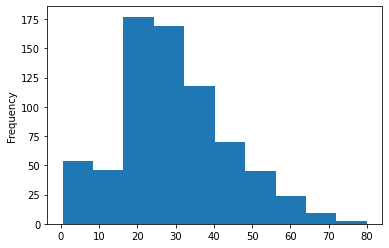

In [6]:
df.Age.plot(kind = 'hist');

### 2.b Transformador de Edad

Dependiendo la estrategia que hayamos decido vamos a necesitar imputar los datos de edad faltantes, ya sea usando un transformador del módulo de pre-procesamiento o crear un transformador custom transformer.
Esto podría implicar:

- Seleccionar una o más columnas
- Llenar los datos faltantes
- Escalar los valores de Edad

In [7]:
from sklearn.pipeline import make_pipeline, make_union
from sklearn.preprocessing import StandardScaler
from sklearn.impute import SimpleImputer
from sklearn.base import BaseEstimator, TransformerMixin

class ColumnSelector(BaseEstimator, TransformerMixin):
    def __init__(self, columns):
        self.columns = columns
    
    def transform(self, X, *_):
        if isinstance(X, pd.DataFrame):
            return pd.DataFrame(X[self.columns])
        else:
            raise TypeError("Este Transformador solo funciona en DF de Pandas")
    
    def fit(self, X, *_):
        return self
    
cs = ColumnSelector('Age')

cs.transform(df).head()

,Age
0,22.0
1,38.0
2,26.0
3,35.0
4,35.0


In [8]:
age_pipe = make_pipeline(ColumnSelector('Age'),
                         SimpleImputer(),
                         StandardScaler())

age_pipe.fit_transform(df)

array([[-0.5924806 ],
       [ 0.63878901],
       [-0.2846632 ],
       [ 0.40792596],
       [ 0.40792596],
       [ 0.        ],
       [ 1.87005862],
       [-2.13156761],
       [-0.20770885],
       [-1.20811541],
       [-1.97765891],
       [ 2.17787603],
       [-0.7463893 ],
       [ 0.71574336],
       [-1.20811541],
       [ 1.94701297],
       [-2.13156761],
       [ 0.        ],
       [ 0.10010856],
       [ 0.        ],
       [ 0.40792596],
       [ 0.33097161],
       [-1.13116105],
       [-0.1307545 ],
       [-1.66984151],
       [ 0.63878901],
       [ 0.        ],
       [-0.82334365],
       [ 0.        ],
       [ 0.        ],
       [ 0.79269771],
       [ 0.        ],
       [ 0.        ],
       [ 2.79351083],
       [-0.1307545 ],
       [ 0.94660642],
       [ 0.        ],
       [-0.66943495],
       [-0.900298  ],
       [-1.20811541],
       [ 0.79269771],
       [-0.20770885],
       [ 0.        ],
       [-2.05461326],
       [-0.82334365],
       [ 0

## 3. Variables Categóricas

"Embarked" y "Pclass" son variables categóricas. Usá la función [`get_dummies`](https://pandas.pydata.org/pandas-docs/stable/reference/api/pandas.get_dummies.html) de pandas para crear columnas correspondientes a los valores de las mismas.

"Embarked" tiene un par de datos faltantes. Llenalos con el puerto de embarque más común en el dataset.

Sugerencia: Crear un transformador custom que "envuelva" el uso de get_dummies.

In [9]:
df.Embarked.value_counts()

S    644
C    168
Q     77
Name: Embarked, dtype: int64

In [10]:
df.Embarked = df.Embarked.fillna('S')

In [11]:
df['Embarked'].value_counts()

S    646
C    168
Q     77
Name: Embarked, dtype: int64

In [12]:
pd.get_dummies(pd.DataFrame(df['Embarked'].head()))

,Embarked_C,Embarked_S
0,0,1
1,1,0
2,0,1
3,0,1
4,0,1


In [13]:
class GetDummiesTransformer(BaseEstimator, TransformerMixin):
    def __init__(self, columns):
        self.columns = columns
    
    def transform(self, X, *_):
        if isinstance(X, pd.DataFrame):
            return pd.get_dummies(X[self.columns], columns = self.columns, drop_first = True)
        else:
            raise TypeError("Este Transformador solo funciona en DF de Pandas")
    
    def fit(self, X, *_):
        return self
    
gdt = GetDummiesTransformer(['Embarked'])
gdt.fit_transform(df).head()

,Embarked_Q,Embarked_S
0,0,1
1,0,0
2,0,1
3,0,1
4,0,1


In [14]:
dummies_pipe = make_pipeline(GetDummiesTransformer(['Pclass', 'Embarked', 'Sex']),
                             StandardScaler())

dummies_pipe.fit_transform(df)[:5,:]

array([[-0.51015154,  0.90258736, -0.30756234,  0.61583843,  0.73769513],
       [-0.51015154, -1.10792599, -0.30756234, -1.62380254, -1.35557354],
       [-0.51015154,  0.90258736, -0.30756234,  0.61583843, -1.35557354],
       [-0.51015154, -1.10792599, -0.30756234,  0.61583843, -1.35557354],
       [-0.51015154,  0.90258736, -0.30756234,  0.61583843,  0.73769513]])

## 4. Tarifa

Escalar el atributo "Fare" (Tarifa) usando uno de los escaladores existentes en el módulo de preprocesamiento. 

In [15]:
fare_pipe = make_pipeline(ColumnSelector('Fare'),
                          StandardScaler())

fare_pipe.fit_transform(df.head())

array([[-0.81614059],
       [ 1.53034706],
       [-0.79140535],
       [ 0.86402362],
       [-0.78682475]])

## 5. Otras columnas

In [16]:
other_pipe = make_pipeline(ColumnSelector(['SibSp', 'Parch']))

## 6. Union

Utilizá una FeatureUnion o la función make_union para combinar todos los pipelines que has creado.

In [17]:
union = make_union(age_pipe,
                   dummies_pipe,
                   fare_pipe,
                   other_pipe)

union.fit_transform(df.head())

array([[-1.50516598,  0.81649658,  0.5       ,  1.22474487, -0.81614059,
         1.        ,  0.        ],
       [ 1.11251398, -1.22474487, -2.        , -0.81649658,  1.53034706,
         1.        ,  0.        ],
       [-0.85074599,  0.81649658,  0.5       , -0.81649658, -0.79140535,
         0.        ,  0.        ],
       [ 0.62169899, -1.22474487,  0.5       , -0.81649658,  0.86402362,
         1.        ,  0.        ],
       [ 0.62169899,  0.81649658,  0.5       ,  1.22474487, -0.78682475,
         0.        ,  0.        ]])

## 7. Predicciones

Ahora utilicemos GridSearch para evaluar la performance de estas transformaciones, seguidas de un modelo de regresión logística. 
Para esto exploren distintos valores de parámetros para C.


Pimero separar las X y las y

In [18]:
X = df[['Pclass', 'Sex', 'Age', 'SibSp', 'Parch', 'Fare', 'Embarked']]
y = df['Survived']
X.head()

,Pclass,Sex,Age,SibSp,Parch,Fare,Embarked
0,3,male,22.0,1,0,7.2500,S
1,1,female,38.0,1,0,71.2833,C
2,3,female,26.0,0,0,7.9250,S
3,1,female,35.0,1,0,53.1000,S
4,3,male,35.0,0,0,8.0500,S


Separar los datos de train y test

In [19]:
from sklearn.model_selection import train_test_split
X_train, X_test, y_train, y_test = train_test_split(X, y, test_size=0.33, random_state=42)
X_train.shape, X_test.shape, y_train.shape, y_test.shape

((596, 7), (295, 7), (596,), (295,))

Aplicar el `pipeline` con todos los objetos transformadores del dataframe

In [20]:
from sklearn.linear_model import LogisticRegression
from sklearn.pipeline import Pipeline
from sklearn.model_selection import GridSearchCV
from sklearn.metrics import classification_report
from sklearn.metrics import accuracy_score

In [21]:
pipeline = Pipeline([('union', union), 
                     ('log', LogisticRegression(solver='liblinear'))])

parameters = {'log__penalty': ['l1', 'l2'],
              'log__C': [0.01, 0.1, 1, 10, 100]}

In [27]:
from sklearn.model_selection import StratifiedKFold

folds=StratifiedKFold(n_splits=5,shuffle=True, random_state=42)

grid_search = GridSearchCV (pipeline, parameters,cv=folds, n_jobs = 5, scoring = 'f1_macro')

In [28]:
grid_search.fit(pd.DataFrame(X_train, columns=X.columns), y_train)

GridSearchCV(cv=StratifiedKFold(n_splits=5, random_state=42, shuffle=True),
             estimator=Pipeline(steps=[('union',
                                        FeatureUnion(transformer_list=[('pipeline-1',
                                                                        Pipeline(steps=[('columnselector',
                                                                                         ColumnSelector(columns='Age')),
                                                                                        ('simpleimputer',
                                                                                         SimpleImputer()),
                                                                                        ('standardscaler',
                                                                                         StandardScaler())])),
                                                                       ('pipeline-2',
                                            

In [29]:
print("Best score: %0.3f" % grid_search.best_score_) 
print("Best parameters set:" )
best_parameters = grid_search.best_estimator_.get_params()
for param_name in sorted (parameters . keys()): 
                    print("\t %s: %r" % (param_name, best_parameters[param_name])) 

Best score: 0.784
Best parameters set:
	 log__C: 0.01
	 log__penalty: 'l2'


#### Performance sobre datos nuevos



In [30]:
y_pred = grid_search.best_estimator_.predict(X_test)

In [31]:
print(classification_report(y_test, y_pred))
print(accuracy_score(y_test, y_pred))

              precision    recall  f1-score   support

           0       0.81      0.87      0.84       175
           1       0.79      0.69      0.74       120

    accuracy                           0.80       295
   macro avg       0.80      0.78      0.79       295
weighted avg       0.80      0.80      0.80       295

0.8
